**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Github Co-pilot has been used as an assistent throughout this worksheet, to help correcting coding errors.

In [311]:
# Write your code here
import numpy as np
from types import SimpleNamespace
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [312]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

We first define all the functions in the model:

In [313]:
#We can now define the functions for the firms optiamal labor demand, profit maximization based on the government budget constraint

def optimal_labor(w, p, A, gamma):
    return (p*A*gamma/w)**(1/(1-gamma))

def optimal_output(w, p, A, gamma):
    return A*(optimal_labor(w, p, A, gamma))**gamma

def profit(w, p, A, gamma):
    return ((1-gamma)/gamma)*w*optimal_labor(w, p, A, gamma)

#We can now define the household utility function and consumption function

# Define the household consumption function with explicit float conversion
def household_consumption(w, T, pi1, pi2, p1, p2, alpha, tau):
    income = w + T + pi1 + pi2
    c1 = alpha * income / p1
    c2 = (1 - alpha) * income / (p2 + tau)
    return float(c1), float(c2)

def utility(c1, c2, nu, alpha, ell, epsilon):
    return np.log(c1**alpha*c2**(1-alpha))-nu*(ell**(1+epsilon) / (1+epsilon))

When all the functions defined, we can now start to find the maarket cleaning conditions for p1 and p2

In [314]:
#First we setup the range for p1 and p2 and w = 1
p_values = np.linspace(0.1, 2.0, 10)
w = 1.0 

# Flag to check if any combination clears the market
any_clearing_combination = False

#We can now calculate the optimal labor demand, output and profit for each price pair
for p1 in p_values:
    for p2 in p_values:
        ell_1 = optimal_labor(w, p1, par.A, par.gamma)
        y_1 = optimal_output(w, p1, par.A, par.gamma)
        pi1 = profit(w, p1, par.A, par.gamma)

        ell_2 = optimal_labor(w, p2, par.A, par.gamma)
        y_2 = optimal_output(w, p2, par.A, par.gamma)
        pi2 = profit(w, p2, par.A, par.gamma)

        #We can now calculate the consumption and utility for each price pair
        c1, c2 = household_consumption(w, par.T, pi1, pi2, p1, p2, par.alpha, par.tau)

        #Finding market clearing conditions
        labor_market_clearing = ell_1 + ell_2
        goods_market_clearing_1 = c1 - y_1 
        goods_market_clearing_2 = c2 - y_2 

       # Check if the markets clear within the a number vclose to zero
        labor_market_clear = np.abs(labor_market_clearing - 1.0) < 1e-8
        goods_market_1_clear = np.abs(goods_market_clearing_1) < 1e-8
        goods_market_2_clear = np.abs(goods_market_clearing_2) < 1e-8

      # Check if all markets clear
        if labor_market_clear and goods_market_1_clear and goods_market_2_clear:
            any_clearing_combination = True
            print(f"Clearing combination found!")
            print(f"p1: {p1:.2f}, p2: {p2:.2f}")
            print(f"Labor market clearing: {labor_market_clearing:.4f}, Clears: {labor_market_clear}")
            print(f"Goods market 1 clearing deviation: {goods_market_clearing_1:.4f}, Clears: {goods_market_1_clear}")
            print(f"Goods market 2 clearing deviation: {goods_market_clearing_2:.4f}, Clears: {goods_market_2_clear}")
            print()

if not any_clearing_combination:
    print("No combination of p1 and p2 clears the markets.")

No combination of p1 and p2 clears the markets.


Hence we cannot find that the market clears at any combination. We could increase the number of steps in the search for prices, and find a market clearing price.

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [315]:
# we first define the market clearing function to find the equilibrium prices. We use the same method as before:

def market_clearing(prices, w, T, alpha, tau, A, gamma):
    p1, p2 = prices
    ell_1 = optimal_labor(w, p1, A, gamma)
    y_1 = optimal_output(w, p1, A, gamma)
    pi1 = profit(w, p1, A, gamma)

    ell_2 = optimal_labor(w, p2, A, gamma)
    y_2 = optimal_output(w, p2, A, gamma)
    pi2 = profit(w, p2, A, gamma)

    c1, c2 = household_consumption(w, T, pi1, pi2, p1, p2, alpha, tau)

    goods_market_clearing_1 = c1 - y_1 
    goods_market_clearing_2 = c2 - y_2 

    return [goods_market_clearing_1, goods_market_clearing_2]

# Simplify to use a single initial guess for finding the equilibrium prices
initial_guess = [1.0, 1.0]
equilibrium_prices = fsolve(market_clearing, initial_guess, args=(w, par.T, par.alpha, par.tau, par.A, par.gamma))
# Round to avoid floating-point comparison issues
equilibrium_prices = np.round(equilibrium_prices, decimals=8)

# Print the equilibrium prices
print(f"Equilibrium: p1 = {equilibrium_prices[0]:.4f}, p2 = {equilibrium_prices[1]:.4f}")

Equilibrium: p1 = 1.0954, p2 = 1.6733


Hence we have an equlibrium at p1 = 1.0954 and p2 = 1.6733

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [316]:
# Define the social welfare function
def social_welfare(tau, w, A, gamma, alpha, nu, epsilon, kappa):
    par.tau = tau

    # Find equilibrium prices with current tau
    equilibrium_prices = fsolve(market_clearing, [1.0, 1.0], args=(w, 0, alpha, tau, A, gamma))
    p1_eq, p2_eq = equilibrium_prices

    ell_1 = optimal_labor(w, p1_eq, A, gamma)
    y_1 = optimal_output(w, p1_eq, A, gamma)
    pi1 = profit(w, p1_eq, A, gamma)

    ell_2 = optimal_labor(w, p2_eq, A, gamma)
    y_2 = optimal_output(w, p2_eq, A, gamma)
    pi2 = profit(w, p2_eq, A, gamma)

    # Calculate initial consumption
    c1, c2 = household_consumption(w, 0, pi1, pi2, p1_eq, p2_eq, alpha, tau)

    # Update T based on tau and c2
    T = tau * c2

    # Recalculate consumption with updated T
    c1, c2 = household_consumption(w, T, pi1, pi2, p1_eq, p2_eq, alpha, tau)
    ell_total = ell_1 + ell_2

    # Utility
    U = utility(c1, c2, nu, alpha, ell_total, epsilon)

    # Social Welfare Function
    SWF = U - kappa * y_2

    return -SWF  # Minimize the negative of SWF to maximize SWF


# Initial guess for tau
initial_tau = 0.1

# Optimize
result = minimize(social_welfare, initial_tau, args=(w, par.A, par.gamma, par.alpha, par.nu, par.epsilon, kappa), bounds=[(0, None)])
optimal_tau = result.x[0]

# Calculate optimal T based on the optimal tau
equilibrium_prices = fsolve(market_clearing, [1.0, 1.0], args=(w, 0, par.alpha, optimal_tau, par.A, par.gamma))
p1_eq, p2_eq = equilibrium_prices
ell_1 = optimal_labor(w, p1_eq, par.A, par.gamma)
y_1 = optimal_output(w, p1_eq, par.A, par.gamma)
pi1 = profit(w, p1_eq, par.A, par.gamma)
ell_2 = optimal_labor(w, p2_eq, par.A, par.gamma)
y_2 = optimal_output(w, p2_eq, par.A, par.gamma)
pi2 = profit(w, p2_eq, par.A, par.gamma)
c1, c2 = household_consumption(w, 0, pi1, pi2, p1_eq, p2_eq, par.alpha, optimal_tau)
optimal_T = optimal_tau * c2

print(f"Optimal tau: {optimal_tau:.2f}, Optimal T: {optimal_T:.2f}")


Optimal tau: 0.79, Optimal T: 0.45


Hence the carbon tax rate is 0.79 and the lump-sum transfer is 0.45 to maximize the social welfare function

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [317]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1


**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [318]:
# Setting seed for reproducibility
np.random.seed(2024)

# Initialize arrays to store expected and realized utilities
expected_utilities = np.zeros(par.J)
realized_utilities = np.zeros(par.J)

# Loop through the simulations of career choices
for j in range(par.J):
    utilities = par.v[j] + np.random.normal(0, par.sigma, par.K)
    expected_utilities[j] = np.mean(utilities)
    realized_utilities[j] = np.mean(utilities)

# Print the results
for j in range(par.J):
    print(f"Career {j+1}: Expected Utility = {expected_utilities[j]:.4f}, Realized Utility = {realized_utilities[j]:.4f}")


Career 1: Expected Utility = 1.0154, Realized Utility = 1.0154
Career 2: Expected Utility = 2.0064, Realized Utility = 2.0064
Career 3: Expected Utility = 3.0030, Realized Utility = 3.0030


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

Career 1: Average Share = 0.1000
Career 2: Average Share = 0.2000
Career 3: Average Share = 0.7000


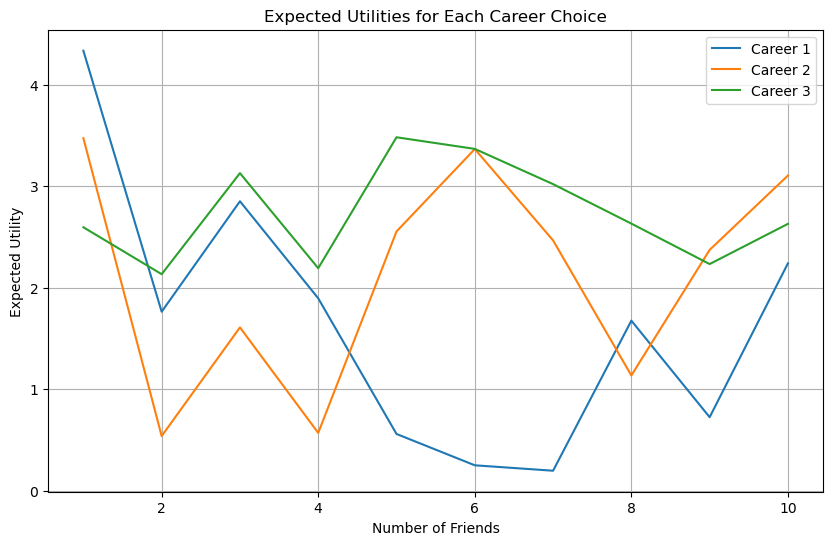

In [319]:
#Setting seed for reproducibility
np.random.seed(2024)

def simulate_graduates_choices(par):
    shares = np.zeros((par.N, par.J))
    expected_utilities = np.zeros((par.N, par.J))
    
    for i in range(par.N):
        friends = par.F[i]
        utilities = np.zeros((par.J, friends))
        
        for j in range(par.J):
            utilities[j, :] = par.v[j] + np.random.normal(0, par.sigma, friends)
            expected_utilities[i, j] = np.mean(utilities[j, :])
        
        best_career = np.argmax(expected_utilities[i, :])
        shares[i, best_career] += 1

    return shares, expected_utilities

# Simulate graduates' choices
shares, expected_utilities = simulate_graduates_choices(par)

# Calculate average shares across all graduates
average_shares = shares.sum(axis=0) / par.N

# Print the results
for j in range(par.J):
    print(f"Career {j+1}: Average Share = {average_shares[j]:.4f}")

# Plot expected utilities
plt.figure(figsize=(10, 6))
for j in range(par.J):
    plt.plot(par.F, expected_utilities[:, j], label=f'Career {j+1}')

plt.xlabel('Number of Friends')
plt.ylabel('Expected Utility')
plt.title('Expected Utilities for Each Career Choice')
plt.legend()
plt.grid(True)
plt.show()


In the plot the number of friends is the x-axis and the y-axis the expecxted utility. We can see that it is varying a lot, but we all have a quite small number of friends. If we where to increase the number of friends, the expected utility would go towards it true mean.
The most common career choice is career 3 based on the simulation. next most common is career 2 and the least is career 1. If N got large, one career would probaly take all the students, since that has the highest expected utility, and hence no one would choose other careers, since there is no information on those.
The career with highest expected utility is 2, when you have 10 friends.

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

Share of students switching careers: 0.3000
Average Subjective Expected Utility: 3.0006
Average Realized Utility: 3.0041
Career 1: Share of students switching careers = 1.0000
Career 2: Share of students switching careers = 1.0000
Career 3: Share of students switching careers = 0.0000

New Expected Utilities:
[[1.01589509 2.00948775 3.00121564]
 [1.00488355 2.01740746 3.02244506]
 [0.98321084 2.03609182 2.99646258]
 [0.97913471 2.02567929 2.99554016]
 [1.0001393  2.01456136 2.97393576]
 [1.00398937 2.01880439 3.00337314]
 [0.98326795 2.02163942 3.0049693 ]
 [0.99536599 2.04134815 2.99734709]
 [1.01201934 2.01551943 3.01126163]
 [0.98988694 2.03351233 2.99977679]]


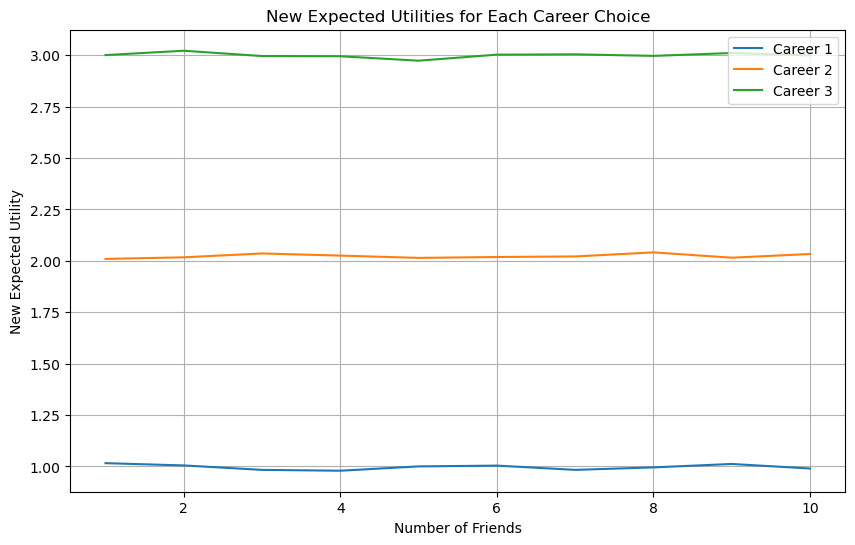

In [320]:
#setting seed for reproducibility
np.random.seed(2024)

def simulate_initial_choices(par):
    initial_choices = np.zeros(par.N, dtype=int)
    expected_utilities = np.zeros((par.N, par.J))
    
    for i in range(par.N):
        friends = par.F[i]
        utilities = np.zeros((par.J, friends))
        
        for j in range(par.J):
            utilities[j, :] = par.v[j] + np.random.normal(0, par.sigma, friends)
            expected_utilities[i, j] = np.mean(utilities[j, :])
        
        best_career = np.argmax(expected_utilities[i, :])
        initial_choices[i] = best_career

    return initial_choices, expected_utilities

def simulate_new_choices(par, initial_choices):
    new_choices = np.zeros(par.N, dtype=int)
    new_expected_utilities = np.zeros((par.N, par.J))
    realized_utilities = np.zeros(par.N)
    
    for i in range(par.N):
        utilities = np.zeros((par.J, par.K))
        
        for j in range(par.J):
            utilities[j, :] = par.v[j] + np.random.normal(0, par.sigma, par.K)
            new_expected_utilities[i, j] = np.mean(utilities[j, :])
        
        best_career = np.argmax(new_expected_utilities[i, :])
        new_choices[i] = best_career
        realized_utilities[i] = np.mean(par.v[best_career] + np.random.normal(0, par.sigma, par.K))

    switch_shares = np.mean(new_choices != initial_choices)
    return switch_shares, new_expected_utilities, realized_utilities, new_choices

# Simulate initial choices
initial_choices, initial_expected_utilities = simulate_initial_choices(par)

# Simulate new choices based on updated information
switch_shares, new_expected_utilities, realized_utilities, new_choices = simulate_new_choices(par, initial_choices)

# Calculate average subjective expected utility from the new optimal career choice
average_subjective_expected_utility = np.mean([new_expected_utilities[i, new_choices[i]] for i in range(par.N)])

# Calculate ex post realized utility from the new optimal career choice
average_realized_utility = np.mean(realized_utilities)

# Calculate share of graduates switching careers conditional on initial career choice
switch_shares_conditional = np.zeros(par.J)
for j in range(par.J):
    initial_career_mask = initial_choices == j
    switch_shares_conditional[j] = np.mean(new_choices[initial_career_mask] != initial_choices[initial_career_mask])

# Print the results
print(f"Share of students switching careers: {switch_shares:.4f}")
print(f"Average Subjective Expected Utility: {average_subjective_expected_utility:.4f}")
print(f"Average Realized Utility: {average_realized_utility:.4f}")
for j in range(par.J):
    print(f"Career {j+1}: Share of students switching careers = {switch_shares_conditional[j]:.4f}")

# Display the new expected utilities
print("\nNew Expected Utilities:")
print(new_expected_utilities)

# Plot new expected utilities
plt.figure(figsize=(10, 6))
for j in range(par.J):
    plt.plot(par.F, new_expected_utilities[:, j], label=f'Career {j+1}')

plt.xlabel('Number of Friends')
plt.ylabel('New Expected Utility')
plt.title('New Expected Utilities for Each Career Choice')
plt.legend()
plt.grid(True)
plt.show()


As seen the shares of students switching switching career is 30%. The expected utility is now more fixed to a level, with career 3 having a utility of 3, career to having a utility of 2 and career 1 having an utility of 1.
We can also see that all people that does not chose career 3 to start with, make the switch to that career.

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [303]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$. + **Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

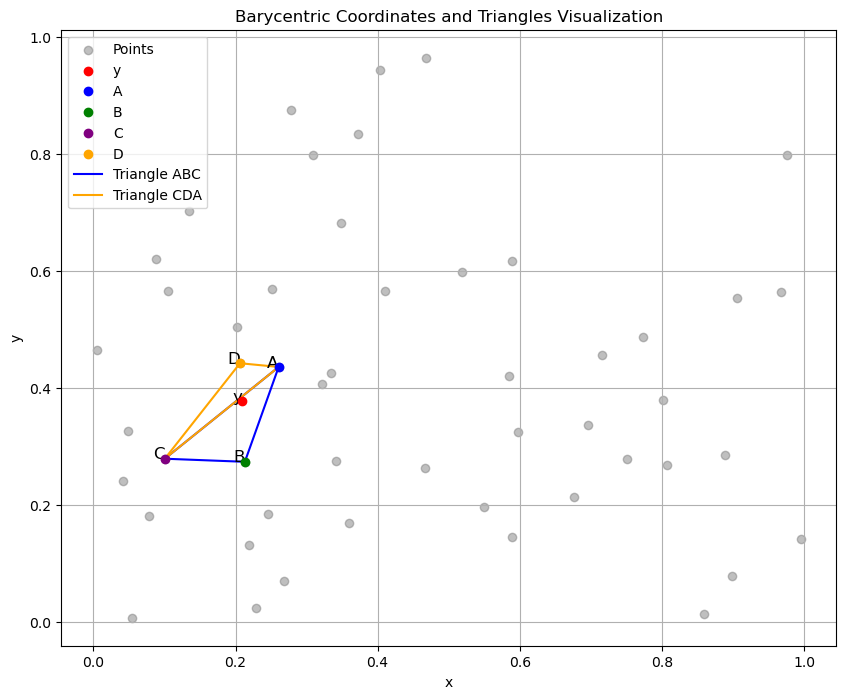

('Point y is inside triangle ABC with barycentric coordinates: 0.6286, 0.0691, 0.3023',
 'Point y is outside triangle CDA.')

In [304]:
# Define functions for barycentric coordinates and triangle check
def barycentric_coordinates(A, B, C, y):
    denomarator = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / denomarator
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / denomarator
    r3 = 1 - r1 - r2
    return r1, r2, r3

def is_inside_triangle(r1, r2, r3):
    return (0 <= r1 <= 1) and (0 <= r2 <= 1) and (0 <= r3 <= 1)

# Find points A, B, C, D based on given criteria
A = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] > y[0] and point[1] > y[1] else float('inf'))
B = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] > y[0] and point[1] < y[1] else float('inf'))
C = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] < y[0] and point[1] < y[1] else float('inf'))
D = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] < y[0] and point[1] > y[1] else float('inf'))

# Plot the points and the triangles
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], label='Points', color='gray', alpha=0.5)
plt.scatter(*y, color='red', label='y', zorder=5)
plt.scatter(*A, color='blue', label='A', zorder=5)
plt.scatter(*B, color='green', label='B', zorder=5)
plt.scatter(*C, color='purple', label='C', zorder=5)
plt.scatter(*D, color='orange', label='D', zorder=5)

# Draw the triangles ABC and CDA 
plt.plot([A[0], B[0]], [A[1], B[1]], 'b-')
plt.plot([B[0], C[0]], [B[1], C[1]], 'b-')
plt.plot([C[0], A[0]], [C[1], A[1]], 'b-', label='Triangle ABC')

plt.plot([C[0], D[0]], [C[1], D[1]], 'orange')
plt.plot([D[0], A[0]], [D[1], A[1]], 'orange')
plt.plot([A[0], C[0]], [A[1], C[1]], 'orange', label='Triangle CDA')

# Annotate the points 
plt.text(y[0], y[1], 'y', fontsize=12, ha='right')
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')
plt.text(D[0], D[1], 'D', fontsize=12, ha='right')

# Set labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Barycentric Coordinates and Triangles Visualization')
plt.legend()
plt.grid(True)
plt.show()

# Compute barycentric coordinates for y with respect to triangles ABC and CDA
rABC1, rABC2, rABC3 = barycentric_coordinates(A, B, C, y)
rCDA1, rCDA2, rCDA3 = barycentric_coordinates(C, D, A, y)

# Check which triangle y is inside
result_abc = ""
result_cda = ""

if is_inside_triangle(rABC1, rABC2, rABC3):
    result_abc = f"Point y is inside triangle ABC with barycentric coordinates: {rABC1:.4f}, {rABC2:.4f}, {rABC3:.4f}"
else:
    result_abc = "Point y is outside triangle ABC."

if is_inside_triangle(rCDA1, rCDA2, rCDA3):
    result_cda = f"Point y is inside triangle CDA with barycentric coordinates: {rCDA1:.4f}, {rCDA2:.4f}, {rCDA3:.4f}"
else:

    result_cda = "Point y is outside triangle CDA."

result_abc, result_cda


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [305]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

Interpolated value: 0.2513
True value: 0.25


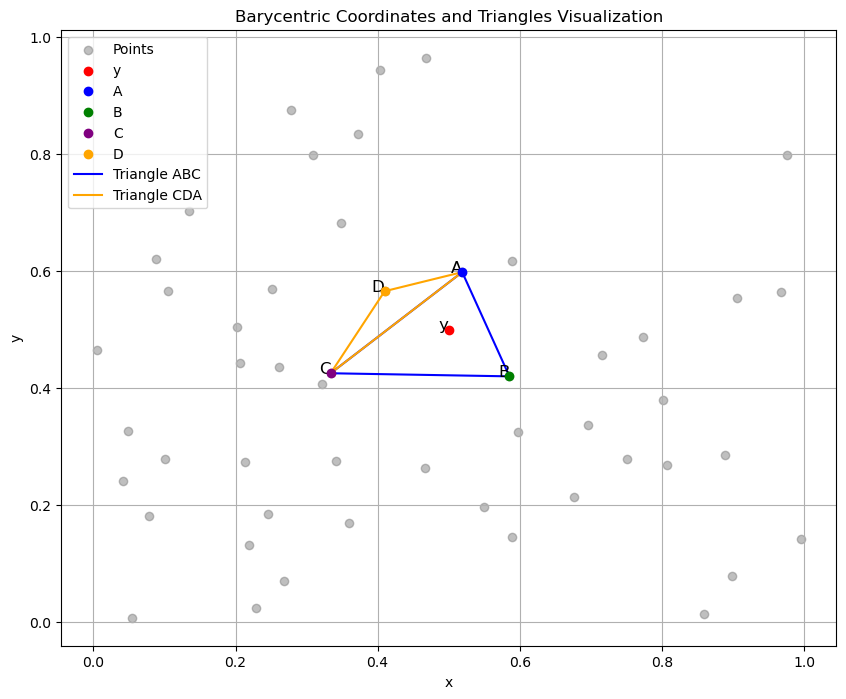

In [309]:

# Compute f values for A, B, C, D
f_A = f(A)
f_B = f(B)
f_C = f(C)
f_D = f(D)


# Check which triangle y is inside and compute the interpolated value
interpolated_value = None

if is_inside_triangle(rABC1, rABC2, rABC3):
    interpolated_value = rABC1 * f_A + rABC2 * f_B + rABC3 * f_C
elif is_inside_triangle(rCDA1, rCDA2, rCDA3):
    interpolated_value = rCDA1 * f_C + rCDA2 * f_D + rCDA3 * f_A
else:
    interpolated_value = np.nan

# Compute the true value of f(y)
true_value = f(y)

print("Interpolated value:", round(interpolated_value, 4))
print("True value:", round(true_value, 4))

# Plot the points and the triangles in 2D
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], label='Points', color='gray', alpha=0.5)
plt.scatter(*y, color='red', label='y', zorder=5)
plt.scatter(*A, color='blue', label='A', zorder=5)
plt.scatter(*B, color='green', label='B', zorder=5)
plt.scatter(*C, color='purple', label='C', zorder=5)
plt.scatter(*D, color='orange', label='D', zorder=5)

# Draw the triangles ABC and CDA
plt.plot([A[0], B[0]], [A[1], B[1]], 'b-')
plt.plot([B[0], C[0]], [B[1], C[1]], 'b-')
plt.plot([C[0], A[0]], [C[1], A[1]], 'b-', label='Triangle ABC')

plt.plot([C[0], D[0]], [C[1], D[1]], 'orange')
plt.plot([D[0], A[0]], [D[1], A[1]], 'orange')
plt.plot([A[0], C[0]], [A[1], C[1]], 'orange', label='Triangle CDA')

# Annotate the points
plt.text(y[0], y[1], 'y', fontsize=12, ha='right')
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')
plt.text(D[0], D[1], 'D', fontsize=12, ha='right')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Barycentric Coordinates and Triangles Visualization')
plt.legend()
plt.grid(True)
plt.show()


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [307]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

Point y: (0.2, 0.2)
Interpolated value: 0.0403
True value: 0.0400

Point y: (0.8, 0.2)
Interpolated value: 0.1587
True value: 0.1600

Point y: (0.8, 0.8)
Interpolated value: nan
True value: 0.6400

Point y: (0.8, 0.2)
Interpolated value: 0.1587
True value: 0.1600

Point y: (0.5, 0.5)
Interpolated value: 0.2513
True value: 0.2500



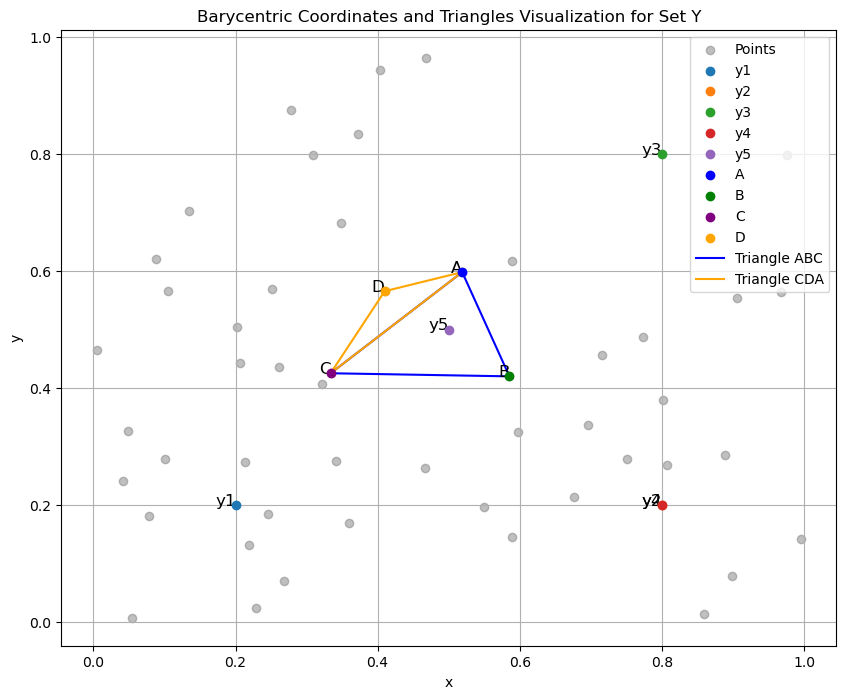

In [310]:
# Initialize lists to store results
interpolated_values = []
true_values = []

for y in Y:
    # Find points A, B, C, D based on given criteria
    A = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] > y[0] and point[1] > y[1] else float('inf'))
    B = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] > y[0] and point[1] < y[1] else float('inf'))
    C = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] < y[0] and point[1] < y[1] else float('inf'))
    D = min(X, key=lambda point: (point[0] - y[0])**2 + (point[1] - y[1])**2 if point[0] < y[0] and point[1] > y[1] else float('inf'))
    
    # Ensure A, B, C, D are distinct points
    if any(np.array_equal(A, pt) for pt in [B, C, D]) or any(np.array_equal(B, pt) for pt in [C, D]) or np.array_equal(C, D):
        interpolated_values.append(np.nan)
        true_values.append(f(y))
        continue
    
    # Compute f values for A, B, C, D
    f_A, f_B, f_C, f_D = compute_f_values(A, B, C, D)
    
    # Compute barycentric coordinates for y with respect to triangles ABC and CDA
    rABC1, rABC2, rABC3 = barycentric_coordinates(A, B, C, y)
    rCDA1, rCDA2, rCDA3 = barycentric_coordinates(C, D, A, y)
    
    # Check which triangle y is inside and compute the interpolated value
    interpolated_value = None
    
    if is_inside_triangle(rABC1, rABC2, rABC3):
        interpolated_value = rABC1 * f_A + rABC2 * f_B + rABC3 * f_C
    elif is_inside_triangle(rCDA1, rCDA2, rCDA3):
        interpolated_value = rCDA1 * f_C + rCDA2 * f_D + rCDA3 * f_A
    else:
        interpolated_value = np.nan
    
    # Compute the true value of f(y)
    true_value = f(y)
    
    # Store the results
    interpolated_values.append(interpolated_value)
    true_values.append(true_value)

# Print the results
for i, y in enumerate(Y):
    print(f"Point y: {y}")
    print(f"Interpolated value: {interpolated_values[i]:.4f}")
    print(f"True value: {true_values[i]:.4f}")
    print()

# Plot the points and the triangles in 2D
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], label='Points', color='gray', alpha=0.5)

# Plot all points in Y
for i, y in enumerate(Y):
    plt.scatter(*y, label=f'y{i+1}', zorder=5)

# Draw the triangles ABC and CDA for the last point in Y for illustration
plt.scatter(*A, color='blue', label='A', zorder=5)
plt.scatter(*B, color='green', label='B', zorder=5)
plt.scatter(*C, color='purple', label='C', zorder=5)
plt.scatter(*D, color='orange', label='D', zorder=5)
plt.plot([A[0], B[0]], [A[1], B[1]], 'b-')
plt.plot([B[0], C[0]], [B[1], C[1]], 'b-')
plt.plot([C[0], A[0]], [C[1], A[1]], 'b-', label='Triangle ABC')
plt.plot([C[0], D[0]], [C[1], D[1]], 'orange')
plt.plot([D[0], A[0]], [D[1], A[1]], 'orange')
plt.plot([A[0], C[0]], [A[1], C[1]], 'orange', label='Triangle CDA')

# Annotate the points
for i, y in enumerate(Y):
    plt.text(y[0], y[1], f'y{i+1}', fontsize=12, ha='right')

plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C[0], C[1], 'C', fontsize=12, ha='right')
plt.text(D[0], D[1], 'D', fontsize=12, ha='right')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Barycentric Coordinates and Triangles Visualization for Set Y')
plt.legend()
plt.grid(True)
plt.show()


As seen on the plot the point y5 is inside the baycentric triangle ABC, and there is no point in ACD.